In [1]:
import os
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
from copy import deepcopy
import numpy as np
import ml_confs
configs = ml_confs.from_file('configs.yaml', register_jax_pytree=False)
configs.tabulate()

┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Key           ┃ Value ┃ Type  ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ classes       │ 5     │ int   │
│ train_samples │ 1001  │ int   │
│ val_ratio     │ 0.2   │ float │
│ test_samples  │ 1001  │ int   │
│ num_rng_seeds │ 20    │ int   │
│ batch_size    │ 128   │ int   │
│ eval_up_to_t  │ 15    │ int   │
│ reduced_rank  │ True  │ bool  │
│ max_epochs    │ 150   │ int   │
│ trial_budget  │ 50    │ int   │
└───────────────┴───────┴───────┘

In [2]:
#List and unpickle all files in "results/"
reports = []
for file in os.listdir("results/"):
    if file.endswith(".pkl"):
        with open("results/"+file, "rb") as f:
            reports.append(pickle.load(f))

def get_series(report, key):
    report = deepcopy(report)
    model_name = report.pop("name")
    series = np.zeros(len(report))
    for k, v in report.items():
        idx = int(k.split('_')[0]) - 2
        series[idx] = v.get(key, 0)
    feature_dims = np.arange(len(report)) + 2
    return feature_dims, series, model_name

def timing_report(report):
    fit_time = f"${report['fit_time']:0.3f}"
    if 'fit_time_std' in report:
        fit_time += f" \pm {report['fit_time_std']:0.3f}$"
    else:
        fit_time += "$"
    if 'time_per_epoch' in report:
        time_per_epoch = f"${report['time_per_epoch']:0.3f}"
        if 'time_per_epoch_std' in report:
            time_per_epoch += f" \pm {report['time_per_epoch_std']:0.3f}$"
        else:
            time_per_epoch += "$"
    else:
        time_per_epoch = "-"
    return report['name'], fit_time, time_per_epoch

In [3]:
list(reports[3].keys())

['accuracy', 'label', 'image', 'fit_time', 'name']

Text(0.5, 1.0, 'Classifier accuracy')

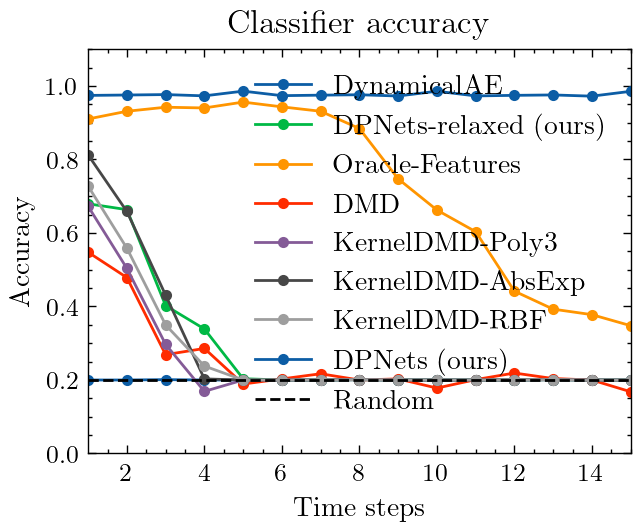

In [4]:
fig, ax = plt.subplots()
for report in reports:
    report = deepcopy(report)
    model_name = report.pop("name")
    t = list(range(1, configs.eval_up_to_t + 1))
    acc = np.array(report['accuracy'])
    if model_name in ['DPNets', 'DPNets-relaxed']:
        model_name = model_name + ' (ours)'
        ax.plot(t, acc, '.-', lw=1.0, label=model_name)
    else:
        ax.plot(t, acc, '.-', label=model_name)

ax.axhline(1/configs.classes, color='black', linestyle='--', label='Random')

ax.legend(frameon=False)
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier accuracy')


In [5]:
from tabulate import tabulate

In [27]:
headers = [r"\textbf{Model}", r"\textbf{Fit Time (s)}", r"\textbf{Time per Epoch (s)}"]
table_records = []
for report in reports:
    table_records.append(timing_report(report))
print(tabulate(table_records, headers=headers, tablefmt="latex_raw", colalign=("right", "center", "center")))

\begin{tabular}{rcc}
\hline
   \textbf{Model} &  \textbf{Fit Time (s)}  &  \textbf{Time per Epoch (s)}  \\
\hline
      DynamicalAE &    $0.571 \pm 0.034$    &       $0.057 \pm 0.003$       \\
   DPNets-relaxed &    $0.043 \pm 0.004$    &       $0.051 \pm 0.004$       \\
  Oracle-Features &         $0.098$         &               -               \\
              DMD &         $0.333$         &               -               \\
  KernelDMD-Poly3 &         $4.914$         &               -               \\
 KernelDMD-AbsExp &         $0.832$         &               -               \\
    KernelDMD-RBF &         $0.776$         &               -               \\
           DPNets &    $0.046 \pm 0.004$    &       $0.049 \pm 0.001$       \\
\hline
\end{tabular}


In [9]:
model_name

['Model Name',
 'DynamicalAE',
 'DPNets-relaxed',
 'Oracle-Features',
 'DMD',
 'KernelDMD-Poly3',
 'KernelDMD-AbsExp',
 'KernelDMD-RBF',
 'DPNets']